In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 0.1.dev19174+g56b5bdf 
Supposed to be 1.0 (21-11-2022)


In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [4]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')
sys.path.append('../')
from Dataset_Creation import sys_dataset
import Dataset_load 

## Read dataset

In [20]:

scale  = 0.05
scaled_amplitude = Parameter('amplitude',
                             value = 4.11e-11 * scale)
dataset_asimov  = Dataset_load.create_asimov(model = 'pl',
                                            parameters = Parameters([scaled_amplitude]))

update evaluator


## Single Cases

In [21]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value


shift_neg = -0.1
shift_pos = +0.1
shift_cor = 0.0

tilt_neg = -0.015
tilt_pos = 0.015
tilt_cor = 0


bias, resolution = 0,0
print(tilt_neg)

-0.015


In [22]:

from gammapy.modeling.models.IRF import IRFModel, ERecoIRFModel, IRFModels, EffAreaIRFModel

effareamodel = EffAreaIRFModel()
IRFmodels = IRFModels(eff_area_model= effareamodel,
                             datasets_names = dataset_asimov.name)
print(IRFmodels.parameters.names)

['norm_nuisance', 'tilt_nuisance', 'reference']


In [23]:
sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_cor, 
                        tilt = tilt_cor,
                        bias = bias,
                        resolution = resolution,
                        rnd = False,
                        e_reco_creation=10)
dataset_cor_N = sys_d_cor.create_dataset_N(10)

dataset_cor = sys_d_cor.create_dataset()


zero = 1e-24
if tilt_pos == 0:
    tilt_assumed = zero
else:
    tilt_assumed = tilt_pos
    
## addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/zero**2, 1/zero**2, 1/shift_pos**2, 1/tilt_assumed**2])
datasets_N  = [ dataset_cor_N, ]
datasets  = [ dataset_cor, ]

if tilt_assumed >zero:
    for d in datasets_N:
        d.irf_model.eff_area_model.parameters['tilt_nuisance'].frozen = False
dataset_cor_N.penalising_invcovmatrix = penalising_invcovmatrix

for d in datasets_N:
    d.irf_model.e_reco_model.parameters.freeze_all()


update evaluator
update evaluator


In [24]:
print(datasets_N[0])

update evaluator
irf model eval
MapDataset
----------

  Name                            : dataset N 

  Total counts                    : 7758 
  Total background counts         : 6714.05
  Total excess counts             : 1044.03

  Predicted counts                : 7758.08
  Predicted background counts     : 6714.05
  Predicted excess counts         : 1044.03

  Exposure min                    : 1.23e+03 m2 s
  Exposure max                    : 1.93e+11 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 1063923 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 72468.14

  Number of models                : 3 
  Number of parameters            : 13
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : gQP4SiG_
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type     

In [25]:
print(datasets[0])

update evaluator
MapDataset
----------

  Name                            : be0jA9B3 

  Total counts                    : 7758 
  Total background counts         : 6714.05
  Total excess counts             : 1044.03

  Predicted counts                : 7758.08
  Predicted background counts     : 6714.05
  Predicted excess counts         : 1044.03

  Exposure min                    : 1.23e+03 m2 s
  Exposure max                    : 1.93e+11 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 1063923 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 72468.14

  Number of models                : 2 
  Number of parameters            : 8
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name                      : gQP4SiG_
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Paramete

In [26]:
import json

def make_writeable(cc):
    d = dict()
    for ii, seg in enumerate(cc.allsegs[0]):
        d['x'] = seg[:,0].tolist()
        d['y'] = seg[:,1].tolist()
    return d

def save(c, name):
    d = make_writeable(c)
    with open(name, 'w') as f:
        json.dump(d, f)
        
def read(name):
    with open(name) as data_file:
        data_loaded = json.load(data_file)
    return data_loaded

## Standard 

update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 152
	total stat : 72468.14

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

CPU times: user 10min, sys: 3min 42s, total: 13min 43s
Wall time: 13min 43s


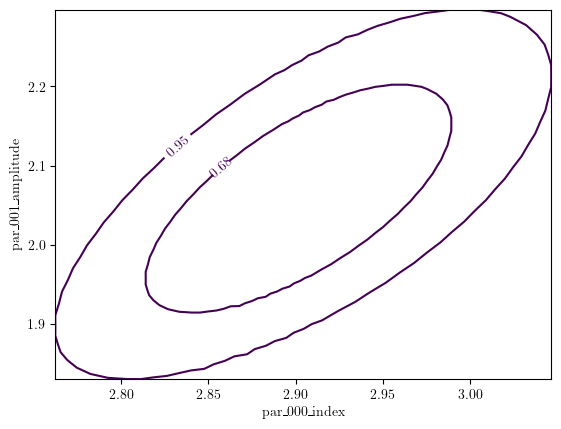

In [27]:
%%time
fit = Fit(store_trace=False)
minuit_opts = {"tol": 0.01, "strategy": 2}
fit.optimize_opts = minuit_opts
result = fit.run(datasets)
print(result)
fitting = 1
if fitting :
    c = fit.minuit.draw_mncontour("par_000_index", "par_001_amplitude", 
                                   cl = 0.68, 
                                   size = 100, 
                                   )
    save(c, 'data/5_scan_68.json')
    c95 = fit.minuit.draw_mncontour("par_000_index", "par_001_amplitude", 
                                   cl = 0.95, 
                                   size = 100, 
                                   )
    save(c95, 'data/5_scan_95.json')
else:
    c = read('data/5_scan_68.json')
    c95 = read('data/5_scan_95.json')
      

## Nuisance Parameters

In [ ]:
%%time
fitting_N = 1
if fitting_N:
    fit_N = Fit(store_trace=False)
    minuit_opts = {"tol": 0.1, "strategy": 2}
    fit_N.optimize_opts = minuit_opts
    result_N = fit_N.run(datasets_N)

    
    c_N = fit_N.minuit.draw_mncontour("par_000_index", "par_001_amplitude", 
                               cl = 0.68, 
                              size = 100, 
                               interpolated = True,
                               )
    
    save(c_N, 'data/5_scan_N_68.json')
    
    print("95")
    c95_N = fit_N.minuit.draw_mncontour("par_000_index", "par_001_amplitude", 
                               cl = 0.95, 
                               size = 100, 
                                interpolated = True,
                               )
    save(c95_N, 'data/5_scan_N_95.json')
else:
    c_N = read('data/5_scan_N_68.json')
    c95_N = read('data/5_scan_N_95.json')
    path = f'data/2_model_nui_{shift}_tilt_{tilt}.yml'
    dataset_N_load = Dataset_load.load_dataset_N(dataset_N, path) 

update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
update evaluator
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf model eval
irf m

# Stat Contours

In [14]:
color_standard = 'crimson'; color_standard_e = 'palevioletred'
color_nui = 'navy'; color_nui_e = 'cornflowerblue' # 'cornflowerblue'
color_rnd = 'darkgreen'
color_input = 'darkorange'
color_eff = 'darkgreen' ; color_eff_e = 'lightgreen'

Text(0, 0.5, 'Amplitude [1e-11 TeV-1 s-1 cm-2]')

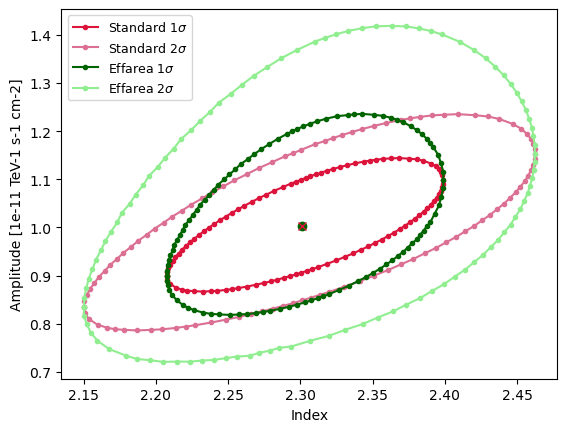

In [17]:
if not fitting and not fitting_N:

    factor = 0.1
    plt.figure()
    plt.plot(c['x'], np.array(c['y'])*factor, '.-', label='Standard 1$\sigma$', color = color_standard)
    plt.plot(c95['x'], np.array(c95['y'])*factor, '.-', label='Standard 2$\sigma$', color = color_standard_e)
    plt.plot(c_N['x'], np.array(c_N['y'])*factor, '.-', label='Effarea 1$\sigma$', color = color_eff)
    plt.plot(c95_N['x'], np.array(c95_N['y']), '.-', label='Effarea 2$\sigma$', color = color_eff_e)
    
    colors_best = [color_eff, color_standard]
    fmts = ['o', 'x']
    for j,d in enumerate([dataset_N_load, datasets]):
        i = d.models.parameters['index'].value
        a = d.models.parameters['amplitude'].value * 1e12
        
        plt.plot(i,a,  fmts[j], color = colors_best[int(j)], )
    
    plt.legend(fontsize=9, loc='best')
    
plt.xlabel("Index")
plt.ylabel("Amplitude [1e-11 TeV-1 s-1 cm-2]")

In [10]:
if fitting:# and fitting_N:

    plt.figure()
    for ii, seg in enumerate(c.allsegs[0]):
        plt.plot(seg[:,0], seg[:,1], '.-', label=c.levels[ii], color = color_standard)
    for ii, seg in enumerate(c95.allsegs[0]):
        plt.plot(seg[:,0], seg[:,1], '.-', label=c95.levels[ii], color = color_standard_e)    


    plt.legend(fontsize=9, loc='best')

In [11]:
if fitting_N:

    plt.figure()
    for ii, seg in enumerate(c_N.allsegs[0]):
        plt.plot(seg[:,0], seg[:,1], '.-', label=c_N.levels[ii], color = color_standard)
    #for ii, seg in enumerate(c95.allsegs[0]):
    #    plt.plot(seg[:,0], seg[:,1], '.-', label=c95.levels[ii], color = color_standard_e)    


    plt.legend(fontsize=9, loc='best')

## Scan 1d

compute edisp
-2.5267712622372523e-33
compute exposure
compute edisp
-2.5267712622372523e-33
compute exposure
compute edisp
-2.5267712622372523e-33
compute exposure
compute edisp
-2.5267712622372523e-33
compute exposure
compute edisp
-2.5267712622372523e-33
compute exposure
compute edisp
-2.5267712622372523e-33
compute exposure
compute edisp
-2.5267712622372523e-33
compute exposure
compute edisp
-2.5267712622372523e-33
compute exposure
compute edisp
-2.5267712622372523e-33
compute exposure
compute edisp
9.999997473228739e-27
compute exposure
compute edisp
-1.0000002526771263e-26
compute exposure
compute edisp
9.999974732287377e-28
compute exposure
compute edisp
-1.0000025267712624e-27
compute exposure
compute edisp
-2.5267712622372523e-33
compute exposure
compute edisp
-2.5267712622372523e-33
compute exposure
compute edisp
-2.5267712622372523e-33
compute exposure
compute edisp
-2.5267712622372523e-33
compute exposure
compute edisp
-2.5267712622372523e-33
compute exposure
compute edisp


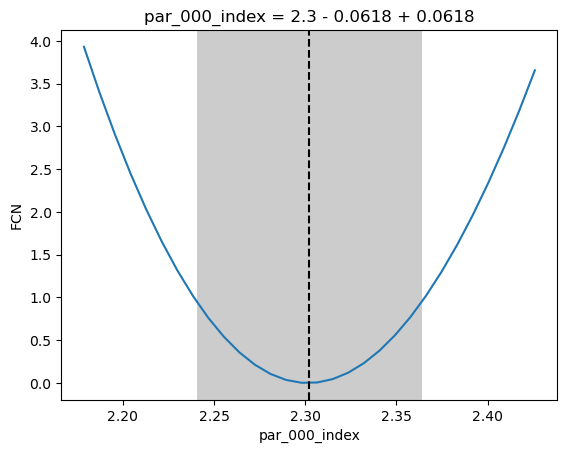

In [18]:
%%time
fitting_scan = True
if fitting_scan:
    fit_N = Fit(store_trace=False)
    minuit_opts = {"tol": 0.1, "strategy": 2}
    fit_N.optimize_opts = minuit_opts
    result_N = fit_N.run(datasets_N)
    scan_index_N = fit_N.minuit.draw_mnprofile("par_000_index");